# 

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from astropy.io import fits
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [20]:
def ensure_native_byteorder(array):
    if array.dtype.byteorder not in ('=', '|'):  # '=' means native, '|' means not applicable
        return array.byteswap().newbyteorder()  # Swap byte order to native
    return array

class APOGEEDataset(Dataset):
    def __init__(self, directory, max_files=None):
        """
        Args:
            directory (string): Directory with all the FITS files.
            max_files (int): Maximum number of FITS files to load (optional).
        """
        self.abundances = []
        self.badflag_count = 0
        all_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.fits')]
        if max_files is not None and max_files < len(all_files):
            self.files = random.sample(all_files, max_files)  # Randomly select max_files from the list
        else:
            self.files = all_files

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        filepath = self.files[idx]
        with fits.open(filepath) as hdul:
            flux = hdul[1].data.astype(np.float32)
            header = hdul[1].header
            wavelength = self.calculate_wavelength(header, flux).astype(np.float32)
            snr = self.get_snr(hdul)


            teff = hdul[4].data['RV_TEFF'][0] if 'RV_TEFF' in hdul[4].columns.names else np.nan
            logg = hdul[4].data['RV_LOGG'][0] if 'RV_LOGG' in hdul[4].columns.names else np.nan
            feh = hdul[4].data['RV_FEH'][0] if 'RV_FEH' in hdul[4].columns.names else np.nan
            ra = hdul[4].data['RA'][0]  
            dec = hdul[4].data['DEC'][0] 
            apogee_starflag = hdul[4].data['APOGEE_STARFLAG'][0] if 'APOGEE_STARFLAG' in hdul[4].columns.names else -1  # Assume -1 if not present

            # if 'ASPCAPFLAG' in hdul[4].columns.names:
            #     mask_flags = hdul[4].data['ASPCAPFLAG'].astype(np.int32)
            # else:
            #     mask_flags = np.zeros_like(flux, dtype=np.int32)  # Fallback to zeros if no mask data

            abundances = hdul[4].data['FELEM'][0].astype(np.float32)
            abundances = np.ascontiguousarray(abundances)
            resolution = wavelength / (header['CDELT1'] * np.mean(wavelength))

            if int(apogee_starflag) == 0 or  int(apogee_starflag) == 3:
                self.badflag_count += 1


            # Ensure the arrays are in the native byte order
            flux = ensure_native_byteorder(flux)
            wavelength = ensure_native_byteorder(wavelength)
            abundances = ensure_native_byteorder(abundances)
            self.abundances.append(abundances)

            # Convert to torch tensors
            flux = torch.from_numpy(flux)
            wavelength = torch.from_numpy(wavelength)
            abundances = torch.from_numpy(abundances)
            flux_mask = self.create_mask(flux.numpy())  
            flux_mask = torch.from_numpy(flux_mask)

            return {'wavelength': wavelength,
                    'flux': flux,
                    'snr': snr, 
                    'teff': teff,
                    'logg': logg, 
                    'feh': feh,
                    'abundances': abundances,
                   'resolution': resolution,
                   'ra': ra,
                   'dec': dec,
                   'flux_mask': flux_mask,
                   'apogee_starflag':apogee_starflag}

         
    def calculate_wavelength(self,header, flux):
        """
        Calculates the wavelength array using the FITS header information.
        """
        crval = header['CRVAL1']  # Starting log10 wavelength
        cdelt = header['CDELT1']  # Log10 wavelength increment
        crpix = header['CRPIX1']  # Reference pixel
        n_pixels = len(flux)
        index = np.arange(n_pixels)
        return 10 ** (crval + (index - (crpix - 1)) * cdelt)

    def get_snr(self, hdul):
        try:
            snr = hdul[4].data['SNR'][0]
            return snr if snr > 0 else 0
        except KeyError:
            return 0

    def create_mask(self, flux):
        """
        Creates a mask for the flux array.
        Args:
            flux (ndarray): Array of flux values.
        Returns:
            ndarray: A mask array where the value is 0 if the corresponding flux is zero, and 1 otherwise.
        """
        return np.where(flux == 0, 0, 1)

    


In [ ]:
directory = '../../projects/k-pop/spectra/apogee/dr17'
dataset = APOGEEDataset(directory, max_files=1000)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

for i in range(len(dataset)):
    _ = dataset[i]



print(f"Number of stars with bad spectra == 0 or 3: {dataset.badflag_count}")


In [4]:
def plot_spectrum(wavelength, flux):
    """
    Plots the spectrum using wavelength and flux data.
    Args:
        wavelength (Tensor): Wavelength data as a PyTorch tensor.
        flux (Tensor): Flux data as a PyTorch tensor.
    """
    # Convert PyTorch tensors to numpy arrays for plotting
    wavelength = wavelength.numpy()
    flux = flux.numpy()
    
    plt.figure(figsize=(10, 6))
    plt.plot(wavelength, flux, label='Spectrum')
    plt.xlabel('Wavelength (Å)')
    plt.ylabel('Flux')
    plt.title('APOGEE Spectrum')
    plt.legend()
    plt.show()


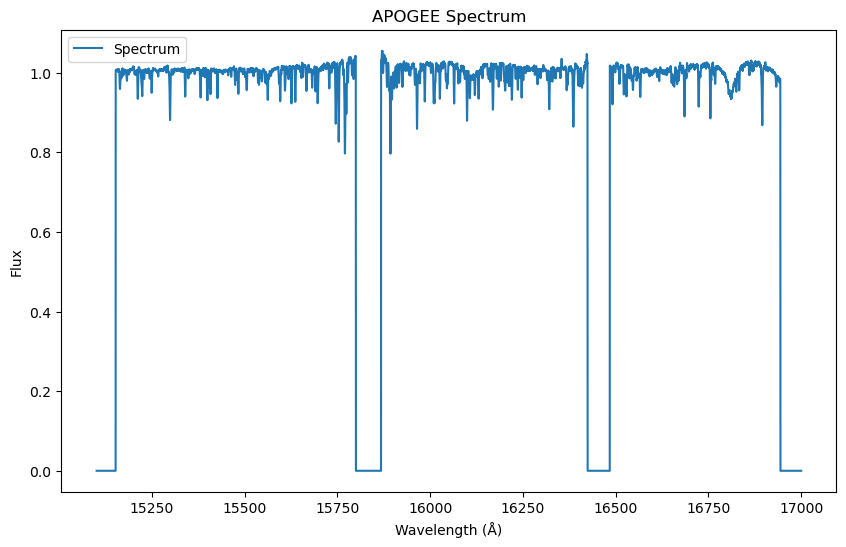

tensor(-1)


In [5]:
for data in dataloader:
    wavelengths, fluxes, apogee_starflag = data['wavelength'], data['flux'], data['apogee_starflag']
    plot_spectrum(wavelengths[0], fluxes[0])  # Plot the first spectrum in the batch
    print(apogee_starflag[0])
    break

In [6]:
def plot_parameter_distribution(dataloader, param_name, bins=30, title=None):
    values_list = []  # Use a list to collect tensors
    # Wrap the dataloader with tqdm for a progress bar
    for data in tqdm(dataloader, desc=f"Processing {param_name}"):
        vals = data[param_name]
        
        # Ensure numpy array is in native byte order before conversion to tensor
        if isinstance(vals, np.ndarray) and vals.dtype.byteorder not in ('=', '|'):
            vals = vals.byteswap().newbyteorder()

        # Remove NaN values directly using PyTorch
        mask = ~torch.isnan(vals)
        valid_vals = vals[mask]  # Use a boolean tensor for indexing
        values_list.append(valid_vals)  # Append valid values to the list

    # Concatenate all valid values into a single tensor after the loop
    values = torch.cat(values_list, dim=0)

    plt.figure(figsize=(10, 6))
    plt.hist(values.numpy(), bins=bins, alpha=0.75, color='blue')  # Convert to numpy for plotting
    plt.title(title or f'Distribution of {param_name}')
    plt.xlabel(param_name)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Print statistics if needed
    if values.numel() > 0:  # Use numel to check for number of elements in tensor
        print(f"Mean {param_name}: {torch.mean(values).item():.2f}")
        print(f"Median {param_name}: {torch.median(values).item():.2f}")
        print(f"Standard Deviation of {param_name}: {torch.std(values).item():.2f}")
    else:
        print("No valid values found. Check your dataset and field names.")


In [7]:

def plot_spectrum_with_mask(wavelength, flux, mask):
    """
    Plots the spectrum and mask using wavelength, flux, and mask data.
    Args:
        wavelength (Tensor): Wavelength data as a PyTorch tensor.
        flux (Tensor): Flux data as a PyTorch tensor.
        mask (Tensor): Mask data as a PyTorch tensor, with values 0 or 1.
    """
    # Convert PyTorch tensors to numpy arrays for plotting
    wavelength = wavelength.numpy()
    flux = flux.numpy()
    mask = mask.numpy() * flux.max()  # Scale mask for visibility on the flux plot

    plt.figure(figsize=(10, 6))
    plt.plot(wavelength, flux, label='Spectrum', color='blue', linestyle='-', linewidth=0.5)
    plt.plot(wavelength, mask, label='Mask', color='red', linestyle='-', linewidth=0.5)
    plt.xlabel('Wavelength (Å)')
    plt.ylabel('Flux')
    plt.title('APOGEE Spectrum with Mask')
    plt.legend()
    plt.show()





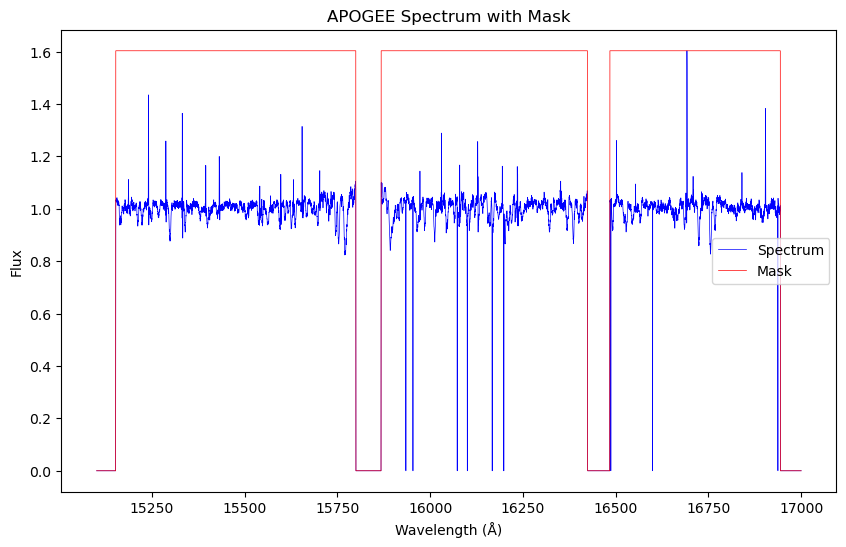

In [8]:
for data in dataloader:
    wavelengths, fluxes, masks = data['wavelength'], data['flux'], data['flux_mask']
    plot_spectrum_with_mask(wavelengths[0], fluxes[0], masks[0])  # Plot the first spectrum and mask in the batch
    break

Processing snr: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


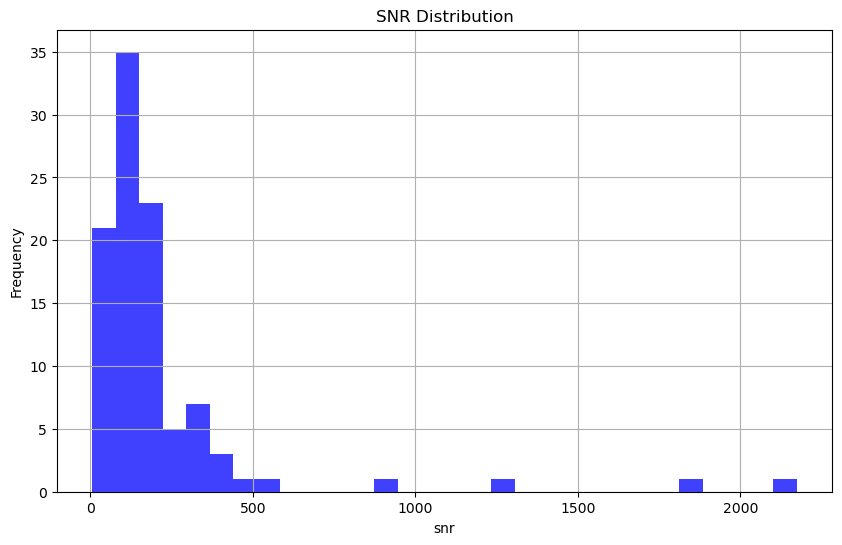

Mean snr: 214.32
Median snr: 133.21
Standard Deviation of snr: 309.97


Processing teff: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


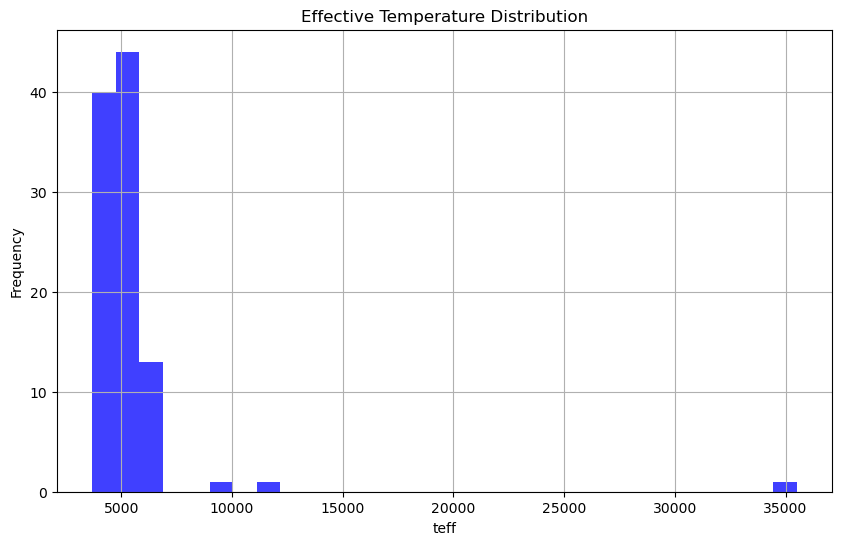

Mean teff: 5309.88
Median teff: 4883.31
Standard Deviation of teff: 3225.44


Processing logg: 100%|██████████| 10/10 [00:03<00:00,  3.05it/s]


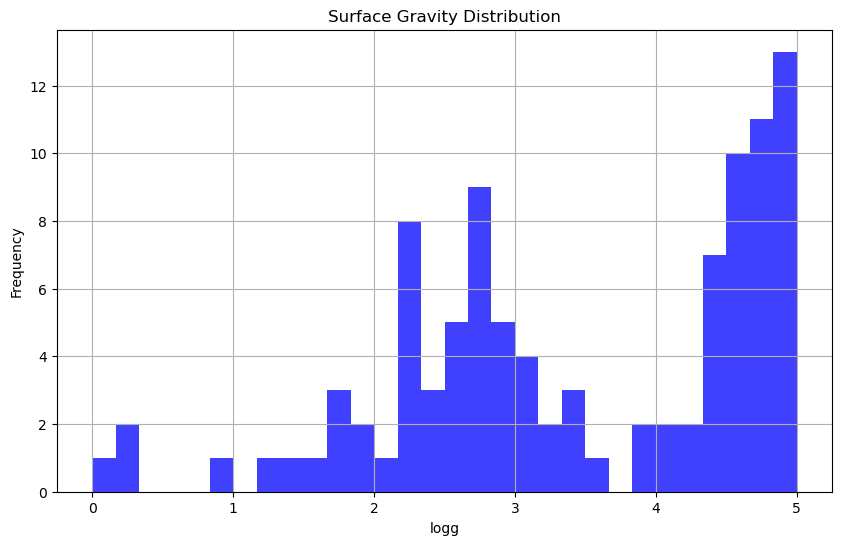

Mean logg: 3.45
Median logg: 3.39
Standard Deviation of logg: 1.28


Processing feh: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


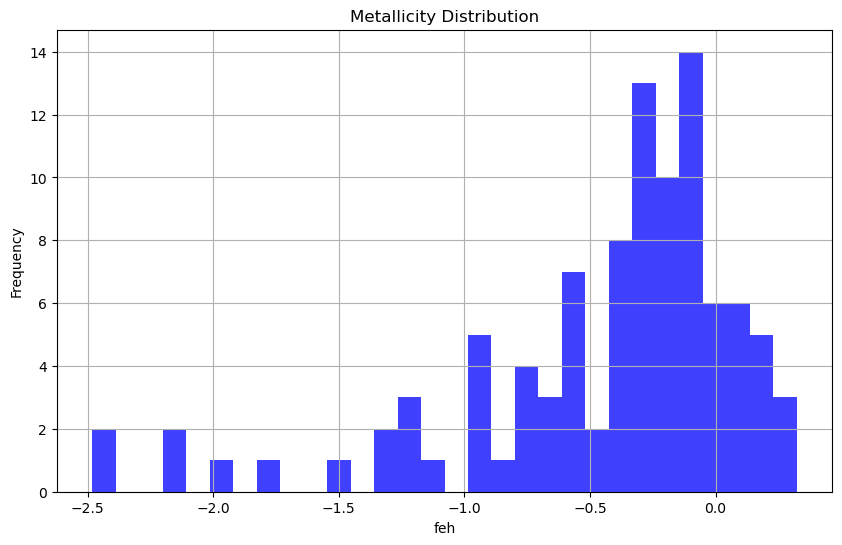

Mean feh: -0.45
Median feh: -0.28
Standard Deviation of feh: 0.59


In [9]:
plot_parameter_distribution(dataloader, 'snr', bins=30, title='SNR Distribution')
plot_parameter_distribution(dataloader, 'teff', bins=30, title='Effective Temperature Distribution')
plot_parameter_distribution(dataloader, 'logg', bins=30, title='Surface Gravity Distribution')
plot_parameter_distribution(dataloader, 'feh', bins=30, title='Metallicity Distribution')


In [10]:
for data in dataloader:
    abundances = data['abundances']
    print(abundances)


    break

tensor([[ 8.4118e-03,  3.7520e-02, -1.5125e-01,  3.0343e-02, -2.8930e-01,
         -1.2189e-02, -1.1596e-02,  7.0712e-02,  3.9999e-02, -4.8517e-02,
         -1.8479e-01,  6.1275e-02, -1.2546e-01, -1.2322e-01,  2.2144e-01,
         -2.2185e-01, -3.0199e-01, -1.5566e-01, -4.8108e-01, -1.2645e-01,
          4.9462e-01,         nan,         nan, -1.3808e-01, -3.4911e-01,
                 nan,  2.3159e-01],
        [-1.7985e-01, -2.4610e-01,  3.3388e-01, -5.1565e-03, -4.5049e-01,
         -4.1600e-02, -3.4461e-01,  2.1612e-02, -4.8358e-01, -3.9414e-02,
         -5.0109e-01,  1.0655e-02, -6.7711e-02,  1.5040e-01, -9.3115e-01,
         -4.6957e-01, -5.9626e-01, -4.7714e-01, -5.0788e-01, -5.4003e-01,
         -1.3767e+00,         nan,         nan, -3.4483e-01, -1.3623e+00,
                 nan, -1.9399e-01],
        [ 2.3153e-02, -4.7696e-04,  2.5576e-01, -9.9645e-03,  1.1812e-01,
          3.8949e-03,  3.1202e-01,  3.8696e-02,  5.2165e-01, -5.5402e-02,
          1.3203e-01,  1.6850e-02,  5.84

In [11]:
for batch in dataloader:
    print(batch['wavelength'].shape, batch['flux'].shape, batch['abundances'].shape)
    break


torch.Size([10, 8575]) torch.Size([10, 8575]) torch.Size([10, 27])


In [12]:
def plot_element_distribution(dataloader, element_index, title=None):
    element_values = []  # List to hold all the abundance values for the specified element
    
    # Iterate through the dataloader to extract the specified element's abundance
    for data in tqdm(dataloader, desc="Extracting element data"):
        abundances = data['abundances']  # Assuming 'abundances' is a key in your data dictionary
        # Append the value at the specified index for each star
        # Use .item() to get the value as a float from the tensor
        element_values.extend(abundances[:, element_index].detach().numpy().tolist())

    # Plotting the distribution
    plt.figure(figsize=(10, 6))
    plt.hist(element_values, bins=30, alpha=0.75, color='blue')
    plt.title(title or f'Distribution of Element at Index {element_index}')
    plt.xlabel('Abundance')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Extracting element data: 100%|██████████| 10/10 [00:03<00:00,  3.09it/s]


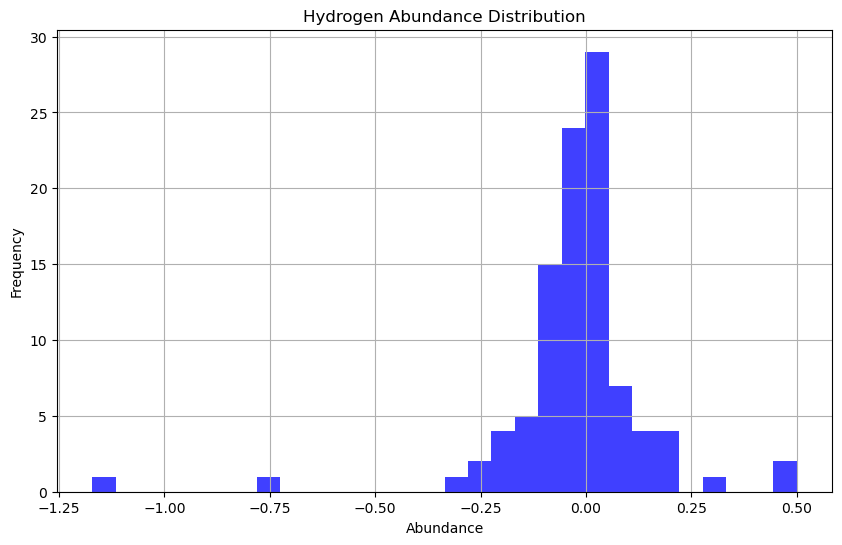

In [13]:
plot_element_distribution(dataloader, 0, title="Hydrogen Abundance Distribution")


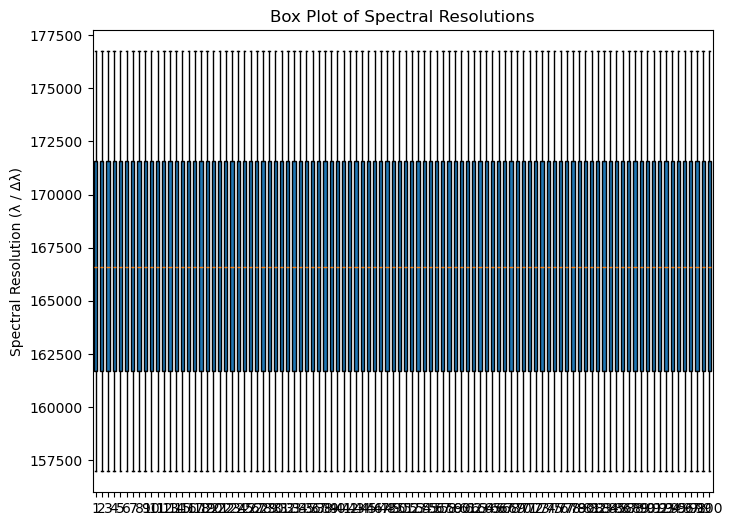

In [14]:
def plot_boxplot_resolution(dataloader):
    resolutions = []
    # Iterate through the DataLoader
    for data in dataloader:
        # Append resolution data from each batch
        batch_resolutions = data['resolution'].detach().cpu().numpy()  # Assuming resolution is a tensor
        resolutions.extend(batch_resolutions)
    
    # Plotting the data
    plt.figure(figsize=(8, 6))
    plt.boxplot(resolutions, vert=True, patch_artist=True)
    plt.title('Box Plot of Spectral Resolutions')
    plt.ylabel('Spectral Resolution (λ / Δλ)')
    # plt.grid(True)
    plt.show()
    
# Assuming you have a DataLoader set up as before
plot_boxplot_resolution(dataloader)



### NOT SURE WHAT TO SEE HERE 

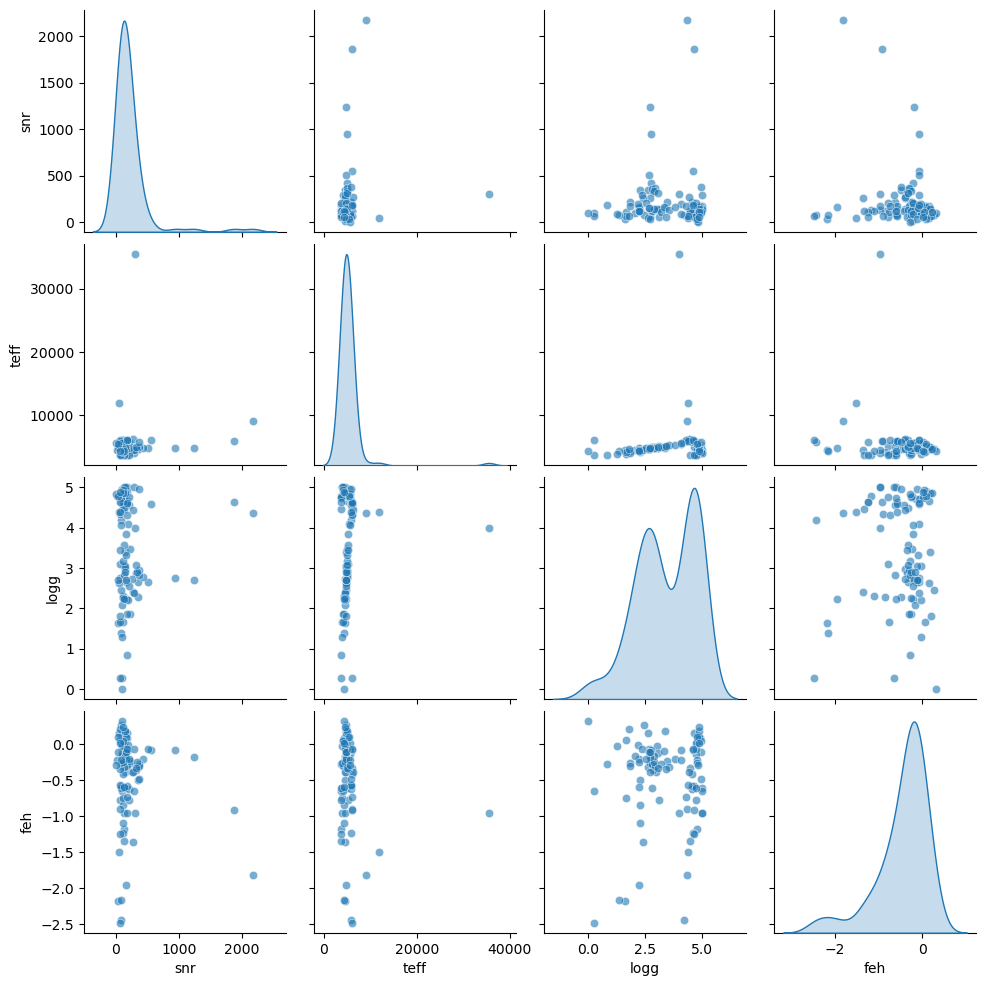

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data loading and cleaning
# Initialize lists to collect data
data_collect = {'snr': [], 'teff': [], 'logg': [], 'feh': []}

# Assuming 'dataloader' is already defined and properly set up
for data in dataloader:
    
 
    data_collect['snr'].extend(data['snr'].cpu().numpy())
    data_collect['teff'].extend(data['teff'].cpu().numpy())
    data_collect['logg'].extend(data['logg'].cpu().numpy())
    data_collect['feh'].extend(data['feh'].cpu().numpy())



# Convert lists to DataFrame
df = pd.DataFrame(data_collect)

# print(df) 

# Drop any rows with NaN values for simplicity or fill them
df.dropna(inplace=True)

# Plotting
sns.pairplot(df, diag_kind='kde', plot_kws={'alpha': 0.6})
plt.show()


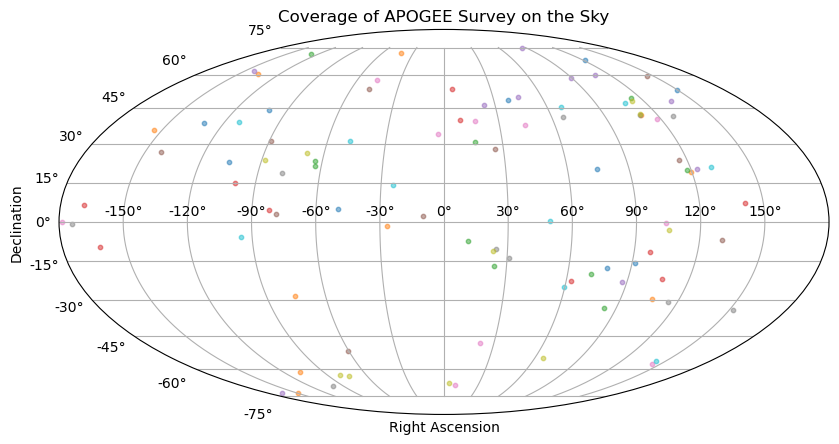

In [16]:
from astropy.coordinates import SkyCoord
import astropy.units as u

def plot_apogee_coverage(dataloader):
    plt.figure(figsize=(10, 5))
    ax = plt.subplot(111, projection="mollweide")
    ax.grid(True)

    for batch in dataloader:
        ra = batch['ra'].numpy()  # Assuming RA is directly available and in degrees
        dec = batch['dec'].numpy()  # Assuming DEC is directly available and in degrees

        # Convert RA, DEC to radians for the plot
        ra_rad = np.radians(ra - 180)  # Adjust RA for the plot
        dec_rad = np.radians(dec)

        ax.scatter(ra_rad, dec_rad, alpha=0.5, s=10)

    ax.set_xlabel('Right Ascension')
    ax.set_ylabel('Declination')
    ax.set_title('Coverage of APOGEE Survey on the Sky')
    plt.show()


plot_apogee_coverage(dataloader)


In [17]:
# import numpy as np
# import matplotlib.pyplot as plt

# def plot_aspcap_flags_histogram(dataset):
#     flags_count = np.zeros(28, dtype=int)  # There are 28 possible flags
#     for data in dataset:
#         flags = data['aspcapflag']
#         for i in range(28):
#             if flags & (1 << i):  # Check if the ith bit is set
#                 flags_count[i] += 1

#     # Define labels for each flag, ensuring each flag has a label
#     labels = [
#         "GridEdge Bad (0)", "CalRange Bad (1)", "Other Bad (2)", 
#         "FERRE Fail (3)", "Param Mismatch Bad (4)", "FERRE Err Used (5)", 
#         "Teff Cut (6)", "Reserved (7)", "GridEdge Warn (8)", "CalRange Warn (9)",
#         "Other Warn (10)", "FERRE Warn (11)", "Param Mismatch Warn (12)",
#         "Optical Warn (13)", "Err Warn (14)", "Faint Warn (15)",
#         "Param Fixed (16)", "RV Warn (17)", "Reserved (18)", "Reserved (19)",
#         "Reserved (20)", "Reserved (21)", "Reserved (22)", "Reserved (23)",
#         "Spec RC (24)", "Spec RGB (25)", "Logg Cal MS (26)", "Logg Cal RGB MS (27)"
#     ]

#     # Plot histogram
#     plt.figure(figsize=(18, 8))
#     bars = plt.bar(range(28), flags_count, tick_label=labels)
#     plt.xlabel('ASPCAP Flags')
#     plt.ylabel('Count')
#     plt.title('Histogram of ASPACAP Flags')
#     plt.xticks(rotation=90)  # Rotate labels to avoid overlap
#     plt.tight_layout()  # Adjust layout to make room for label rotation
#     plt.show()

# # Example of how to use the function
# # plot_aspcap_flags_histogram(apogee_dataset)
